In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

In [2]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [3]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


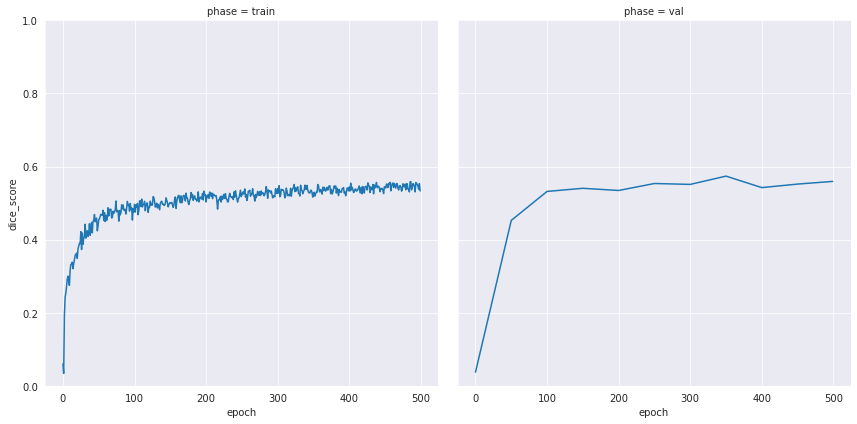

In [5]:
best_exp.vis_loss_curves(height=6)

In [6]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.WMH
annotator: observer_o12
axis: 0
split: val 
num_slices: 1
slicing: midslice 
task: Amsterdam 
version: 0.2

<IPython.core.display.Javascript object>

In [7]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
WMH_Dataset = dataset_cls(**dataset_cfg)
wmh_dataloader = DataLoader(WMH_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
from ionpy.util.torchutils import to_device
import torch
import numpy as np
from tqdm.notebook import tqdm
from ionpy.metrics import dice_score
import einops

def get_dataset_perf(
        exp, 
        dataloader, 
        slice_batch_size=1,
        background_threshold=0.0001
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            
            # Reshape to a good size
            x = einops.rearrange(x, "b c h w -> (b c) 1 h w")
            y = einops.rearrange(y, "b c h w -> (b c) 1 h w")
                             
            yhat = exp.model(x)  
            fore_regions = (y==1)
            back_regions = (y==0)
            
            # Extract predictions
            soft_foreground_pred = torch.sigmoid(yhat)
            # If you want to eliminate background pixels, do so
            if background_threshold > 0:
                soft_foreground_pred[soft_foreground_pred < background_threshold] = 0

            soft_background_pred = 1 - soft_foreground_pred 

            hard_foreground_pred = (soft_foreground_pred > 0.5).float()
            hard_background_pred = 1 - hard_foreground_pred

            # Compute metrics
            dice_met = np.round(dice_score(yhat, y).cpu().numpy(), 3)
            loss_image = (y - soft_foreground_pred) # Not really all that meaningful, just looking at per-pixel differences (can be thought of as soft accuracy).

            ## Calculate calibration image.

            # The calibration image is define as PER-PIXEL the difference between (accu(P) - conf(P)).
            calibration_image = torch.zeros_like(loss_image)
            foreground_accuracy = (y == hard_foreground_pred).float()
            background_accuracy = ((1 - y) == hard_background_pred).float()

            # Set the regions of the image corresponding to groundtruth label.
            calibration_image[fore_regions] = (foreground_accuracy - soft_foreground_pred).abs()[fore_regions]
            calibration_image[back_regions] = (background_accuracy - soft_background_pred).abs()[back_regions]
            
            ## Finally, we want to calculate two tensors (one for each class) that consists of two channels:
            # 1. The match of the prediction
            # 2. The confidence of the prediction
            pix_info = {
                "foreground": torch.stack([foreground_accuracy, soft_foreground_pred], dim=0).view(2, -1).cpu().numpy(),
                "background": torch.stack([background_accuracy, soft_background_pred], dim=0).view(2, -1).cpu().numpy()
            }

            # Wrap it in an item
            items.append({
                "image": x.cpu().squeeze(),
                "label": y.cpu().squeeze(),
                "soft_pred": soft_foreground_pred.cpu().squeeze(),
                "hard_pred": hard_foreground_pred.cpu().squeeze(),
                "dice_score": dice_met,
                "loss": loss_image.cpu().squeeze(),
                "calibration err": calibration_image.cpu().squeeze(),
                "pix_info": pix_info
            })

    return items

In [9]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_dict = get_dataset_perf(
    exp=best_exp, 
    dataloader=wmh_dataloader
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(perf_dict):
    # We are going to visualize 5 things here
    # - The image
    # - The ground truth
    # - The hard prediction (with loss above it)
    # - The delta between the ground truth and the soft prediction
    # - The Calibration error (Acc - Soft Pred)

    color_dict = {
        "loss": "twilight",
        "calibration err": "plasma",
    }

    skip_keys = ["pix_info"]

    for subj in perf_dict:

        # Create the subplots for this subject
        num_keys = len(subj.keys()) - len(skip_keys)
        f, axarr = plt.subplots(1, num_keys, figsize=(5 * num_keys, 5))

        for k_idx, key in enumerate(subj.keys()):
            if key not in skip_keys:
                if key in color_dict:
                    im = axarr[k_idx].imshow(subj[key], cmap=color_dict[key])
                else:
                    im = axarr[k_idx].imshow(subj[key], cmap="gray")
                axarr[k_idx].axis("off")
                axarr[k_idx].set_title(key)
                f.colorbar(im, ax=axarr[k_idx])

        plt.show()

In [11]:
from ese.experiment.metrics import ECE
from ese.experiment.analysis.plots import plot_reliability_diagram

def plot_calibration_plot(
    pred_dict, 
    num_bins,
    ):

    # Get the prediction info.
    pixel_info = [subj["pix_info"] for subj in pred_dict]

    # Establish color scheme.
    label_dict = {
        "foreground": "blue",
        "background": "green"
    }

    # Build the figure
    _, ax = plt.subplots(2, len(num_bins), figsize=(len(num_bins)*6, 12))
    axis_lower_bound = 1 / len(label_dict.keys())

    # Loop through our labels
    for l_idx, label in enumerate(label_dict.keys()):

        accuracies = np.concatenate([pi[label][0] for pi in pixel_info])
        confidences = np.concatenate([pi[label][1] for pi in pixel_info])

        # One issue is that we want to look maybe with different bin sizes, so 
        # lets look at a range.
        for g_idx in range(len(num_bins)):
            
            # Calulate the bins and spacing
            interval_size = 1 / num_bins[g_idx]
            all_bins = np.linspace(0, 1, num_bins[g_idx] + 1)[:-1] # Off by one error, chop off the highest number.

            bins = all_bins[all_bins >= axis_lower_bound]

            # For each bin, calculate the mean accuracy within the bin  
            bar_heights = [np.mean(accuracies[(confidences >= b) & (confidences < (b + interval_size))]) for b in bins]

            if len(num_bins) == 1:
                target_ax = ax[l_idx]
            else:
                target_ax = ax[l_idx, g_idx]

            plot_reliability_diagram(
                bins,
                bar_heights,
                ax=target_ax,
                title=f"{label}, {num_bins[g_idx]} Bins, ECE: {ECE(accuracies, confidences, bins=bins, lower_bound=0.5)}",
  
                bin_color=label_dict[label]
            )

    plt.show()

# 1. What if we mix all calibration errors from all of the pixels of all of the images? Here is that histogram.

In [12]:
# plot_calibration_plot(
#     pred_dict=predictions_dict,
#     num_bins=[10]
#     )

# 2. Let's look at how the ECE looks like if we evaluate over subjects, and what the distribution looks like.

In [13]:
ece_foreground_scores = [ECE(bins=np.linspace(0.5, 1, 10)[:-1],
                             confidences=torch.from_numpy(subj["pix_info"]["foreground"][1]), 
                             accuracies=torch.from_numpy(subj["pix_info"]["foreground"][0]), 
                             reduce="mean") for subj in predictions_dict]

In [14]:
np.mean(ece_foreground_scores)

0.2709839519295528

<Axes: ylabel='Count'>

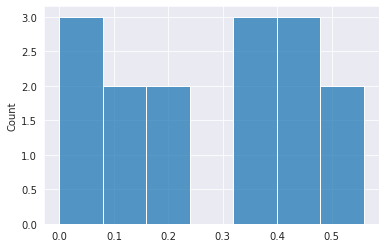

In [15]:
sns.histplot(ece_foreground_scores, bins=7)

# 3. Expected Semantic Error (ESE) 

ESE: [7.60520197e-05 6.28109723e-02 1.36673957e-01 9.63837504e-02
 5.31454086e-02 3.23726833e-01 1.35475755e-01 2.42402613e-01
 8.36893857e-01 0.00000000e+00]
Accuracy: [1.98776761e-04 2.03703701e-01 1.15384616e-01 2.50000000e-01
 5.00000000e-01 2.30769232e-01 5.00000000e-01 5.00000000e-01
 0.00000000e+00 0.00000000e+00]
Bin Counts: [6.54e+04 5.40e+01 2.60e+01 1.60e+01 1.40e+01 1.30e+01 8.00e+00 4.00e+00
 1.00e+00 0.00e+00]


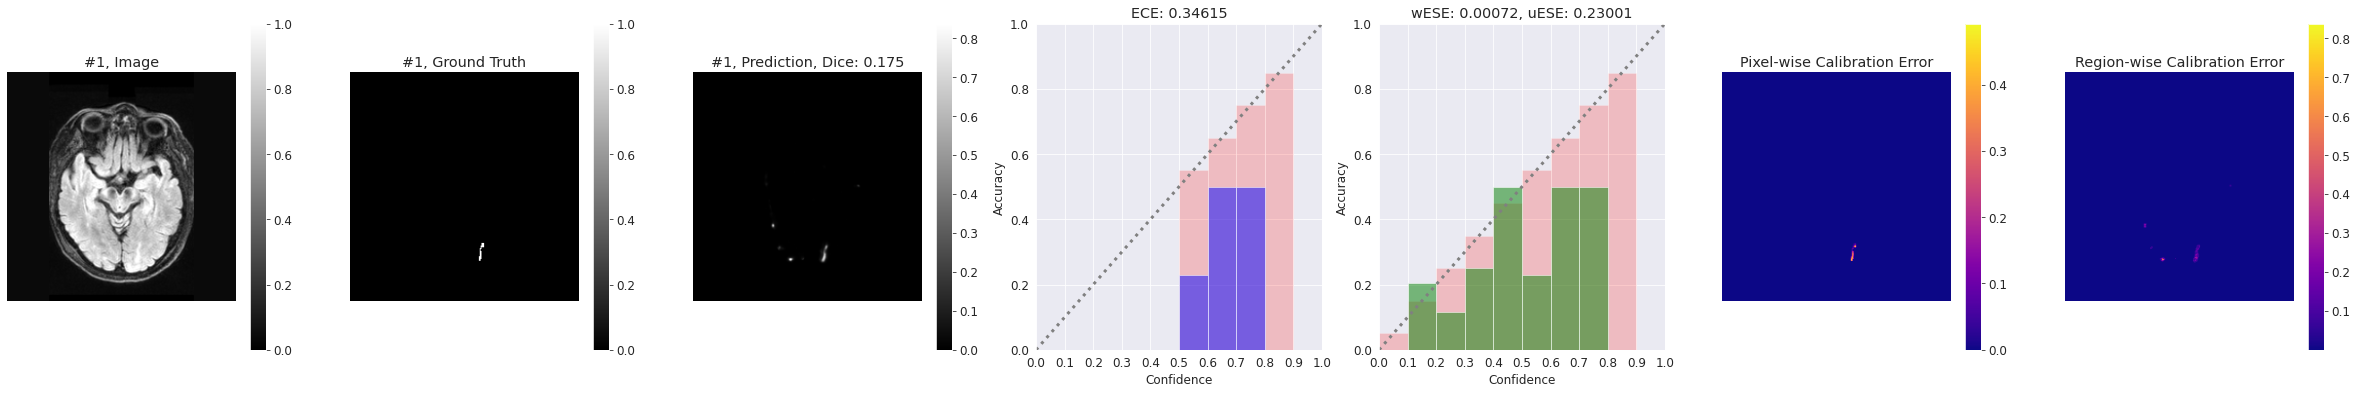

ESE: [2.97821854e-04 7.88866580e-02 6.05063438e-02 3.38106751e-02
 2.28790104e-01 4.93935347e-02 0.00000000e+00 4.86326218e-03
 6.21619105e-01 3.24336648e-01]
Accuracy: [4.12471942e-04 2.22222224e-01 1.81818187e-01 3.33333343e-01
 6.66666687e-01 6.00000024e-01 0.00000000e+00 7.50000000e-01
 2.50000000e-01 6.42857134e-01]
Bin Counts: [6.5459e+04 2.7000e+01 1.1000e+01 6.0000e+00 6.0000e+00 5.0000e+00
 0.0000e+00 4.0000e+00 4.0000e+00 1.4000e+01]


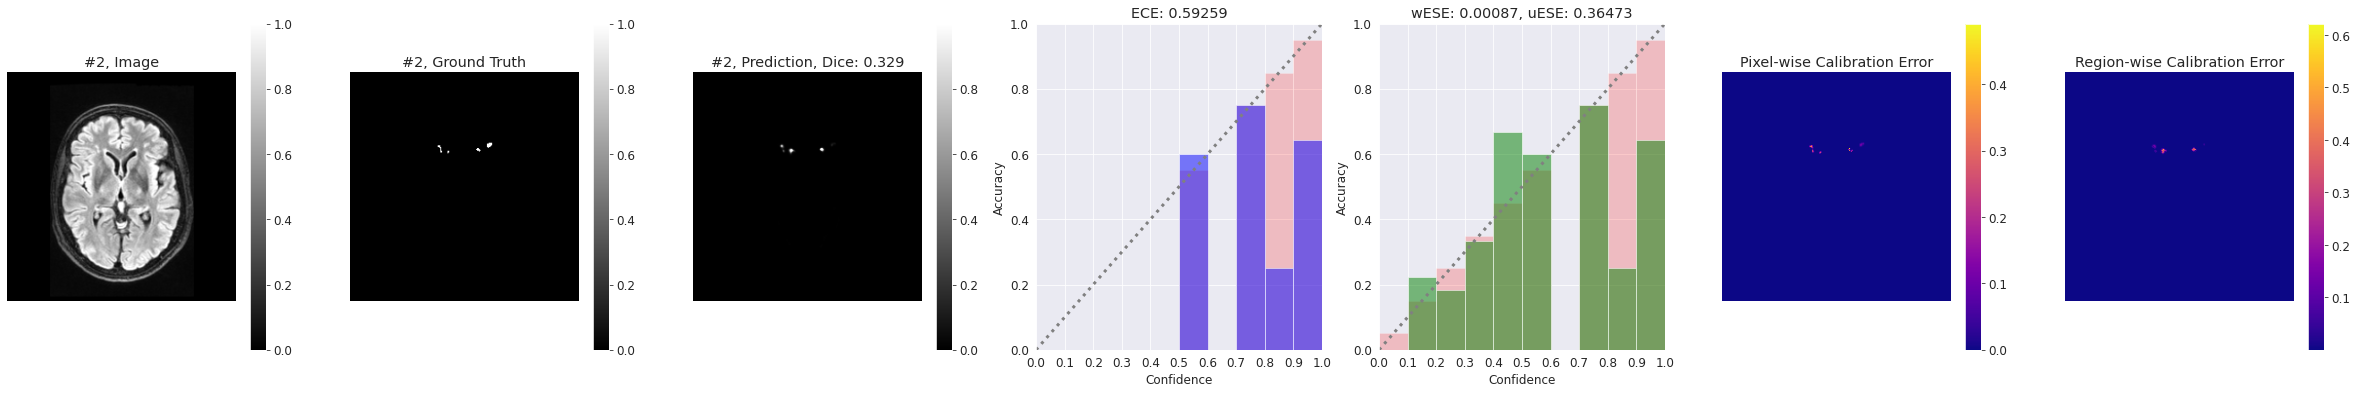

ESE: [2.32318009e-04 6.06792495e-02 7.70910084e-02 1.92523003e-04
 1.46266401e-01 3.12430561e-01 2.34214872e-01 3.25171322e-01
 5.38111091e-01 4.52916145e-01]
Accuracy: [1.69528095e-04 8.20895508e-02 1.66666672e-01 3.43750000e-01
 3.03030312e-01 2.35294119e-01 4.11764711e-01 4.28571433e-01
 3.14285725e-01 5.27918756e-01]
Bin Counts: [6.4886e+04 1.3400e+02 8.4000e+01 6.4000e+01 3.3000e+01 3.4000e+01
 3.4000e+01 3.5000e+01 3.5000e+01 1.9700e+02]


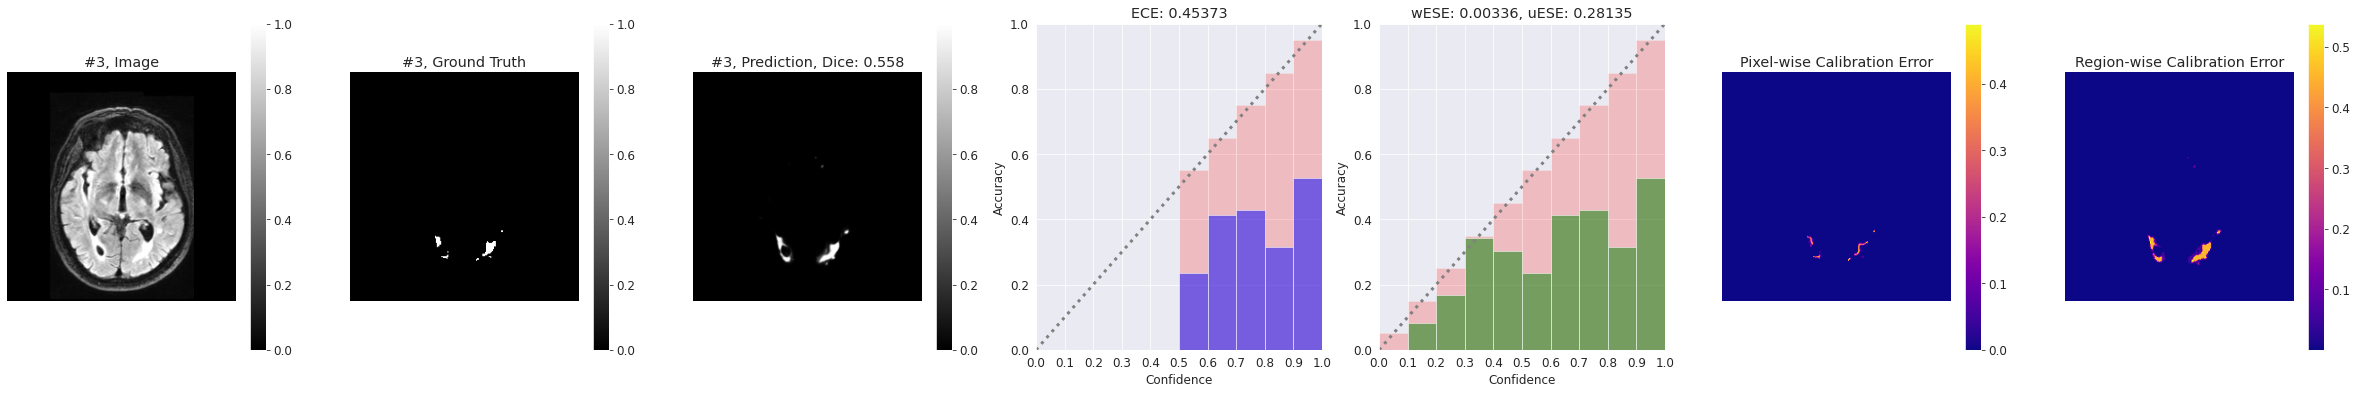

ESE: [1.30937260e-04 1.51837617e-02 6.80711418e-02 5.40204644e-02
 6.19800091e-02 2.80641019e-01 3.17627043e-01 5.23217916e-02
 5.52010536e-01 6.13123655e-01]
Accuracy: [2.60900269e-04 1.28205135e-01 1.73076928e-01 2.89473683e-01
 3.79310340e-01 2.69230783e-01 3.33333343e-01 6.95652187e-01
 2.85714298e-01 3.66666675e-01]
Bin Counts: [6.5159e+04 1.1700e+02 5.2000e+01 3.8000e+01 2.9000e+01 2.6000e+01
 1.8000e+01 2.3000e+01 1.4000e+01 6.0000e+01]


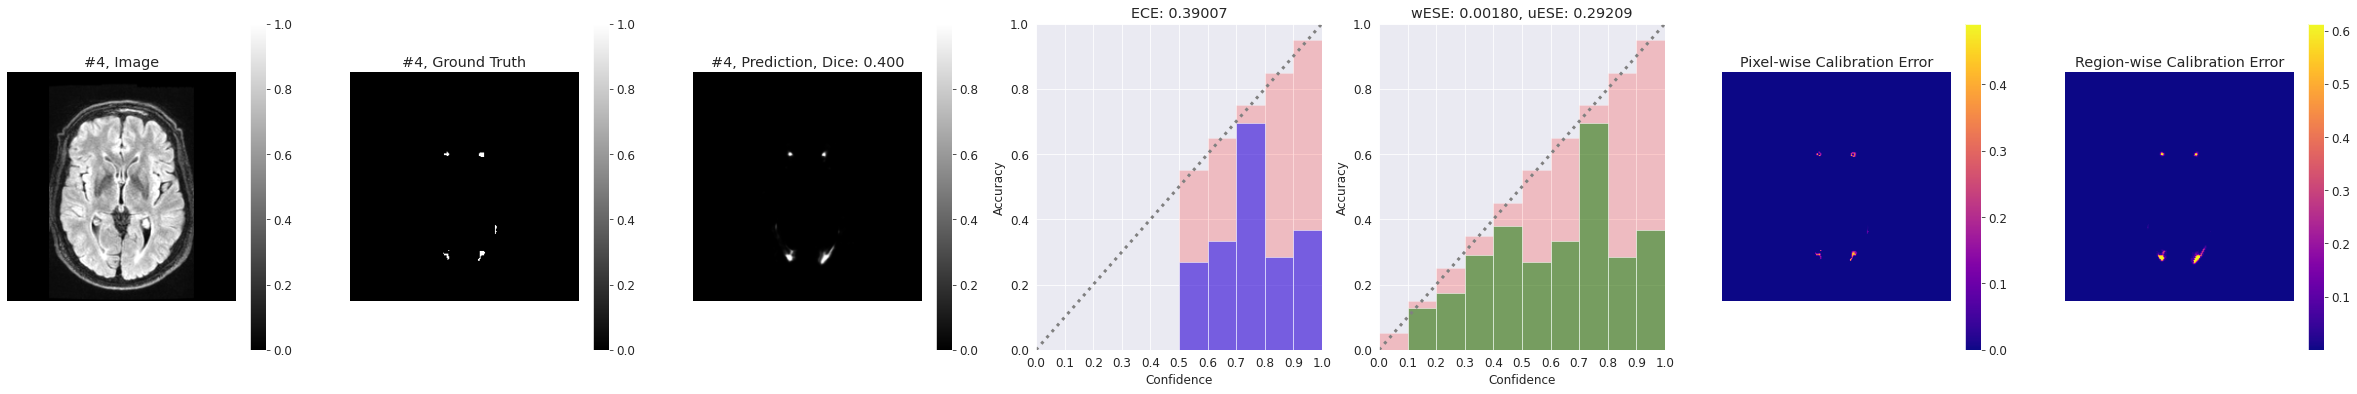

ESE: [1.25394115e-04 6.48300499e-02 1.56586826e-01 9.73485112e-02
 1.39791816e-01 2.57429719e-01 1.68985009e-01 2.11625099e-01
 2.27866173e-01 1.12494588e-01]
Accuracy: [3.07276292e-04 2.08333328e-01 8.92857164e-02 2.50000000e-01
 3.12500000e-01 2.96296299e-01 4.81481493e-01 5.38461566e-01
 6.19047642e-01 8.63157868e-01]
Bin Counts: [6.5088e+04 1.2000e+02 5.6000e+01 4.4000e+01 3.2000e+01 2.7000e+01
 2.7000e+01 2.6000e+01 2.1000e+01 9.5000e+01]


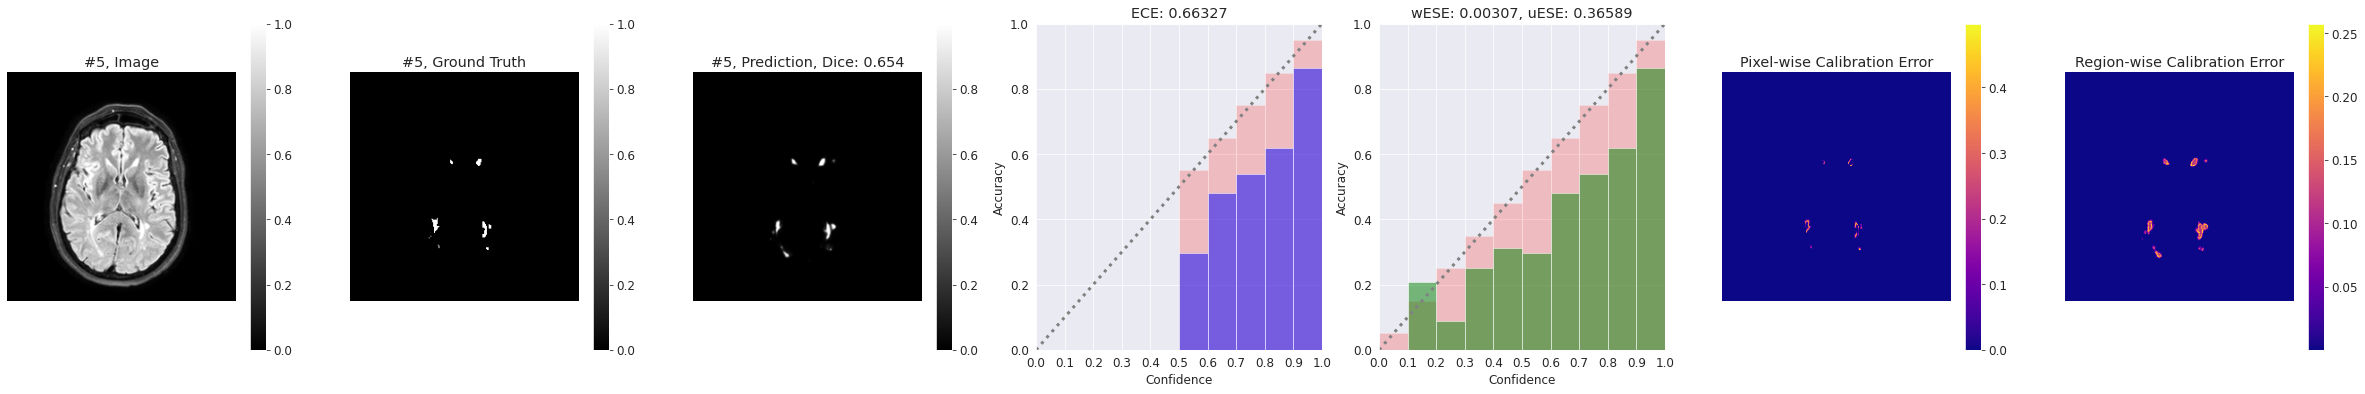

ESE: [1.63476332e-04 2.00527608e-02 7.10023195e-02 3.52894664e-02
 2.67023742e-02 3.13460827e-03 9.34736133e-02 1.96378529e-01
 1.41535223e-01 4.24098969e-02]
Accuracy: [7.67754318e-05 1.63934425e-01 3.05555552e-01 3.21428567e-01
 4.28571433e-01 5.50000012e-01 5.55555582e-01 5.62500000e-01
 7.08333313e-01 9.48453605e-01]
Bin Counts: [6.5125e+04 6.1000e+01 3.6000e+01 2.8000e+01 1.4000e+01 2.0000e+01
 1.8000e+01 1.6000e+01 2.4000e+01 1.9400e+02]


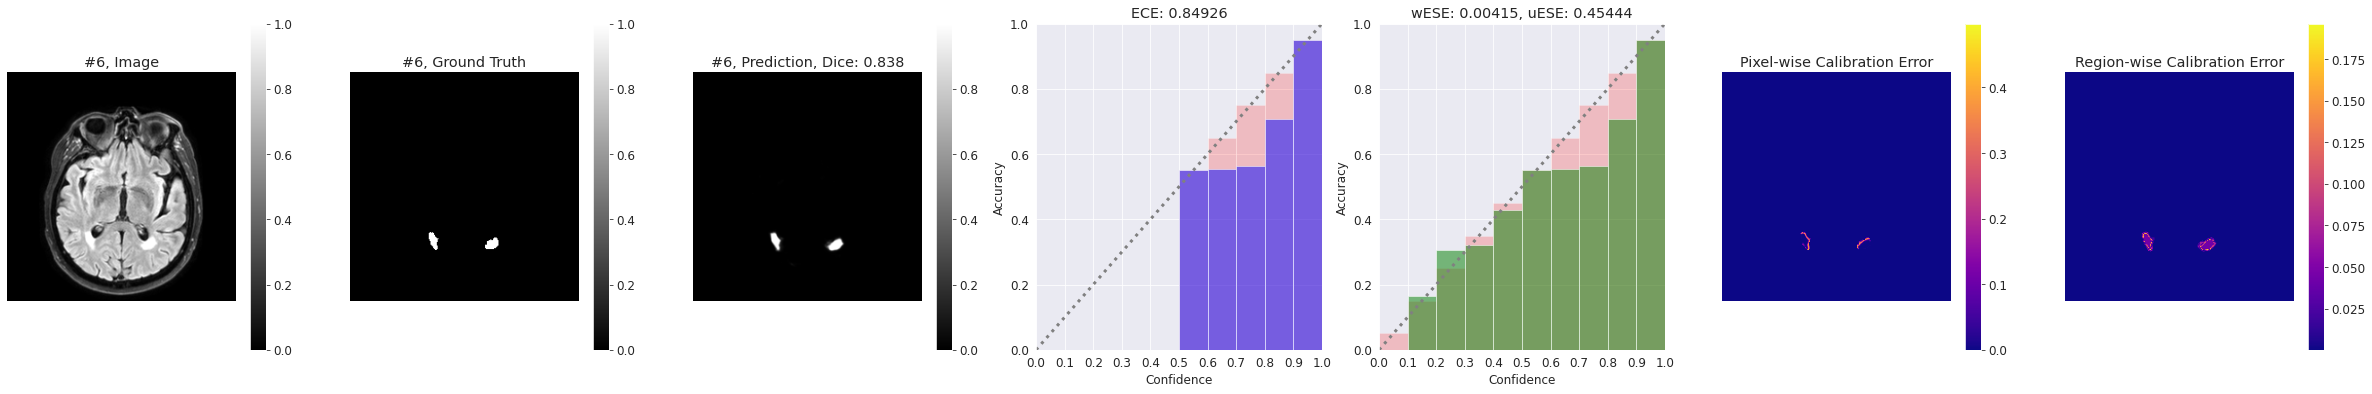

ESE: [4.85430879e-04 9.70638320e-02 1.73805773e-01 2.22384378e-01
 2.40341976e-01 2.24505216e-01 3.63490433e-01 4.22966838e-01
 4.07769054e-01 5.68612456e-01]
Accuracy: [6.17464975e-05 4.65116277e-02 8.04597735e-02 1.26760557e-01
 2.06349209e-01 3.23076934e-01 2.90909082e-01 3.26923072e-01
 4.47368413e-01 4.07894731e-01]
Bin Counts: [6.4781e+04 1.7200e+02 8.7000e+01 7.1000e+01 6.3000e+01 6.5000e+01
 5.5000e+01 5.2000e+01 3.8000e+01 1.5200e+02]


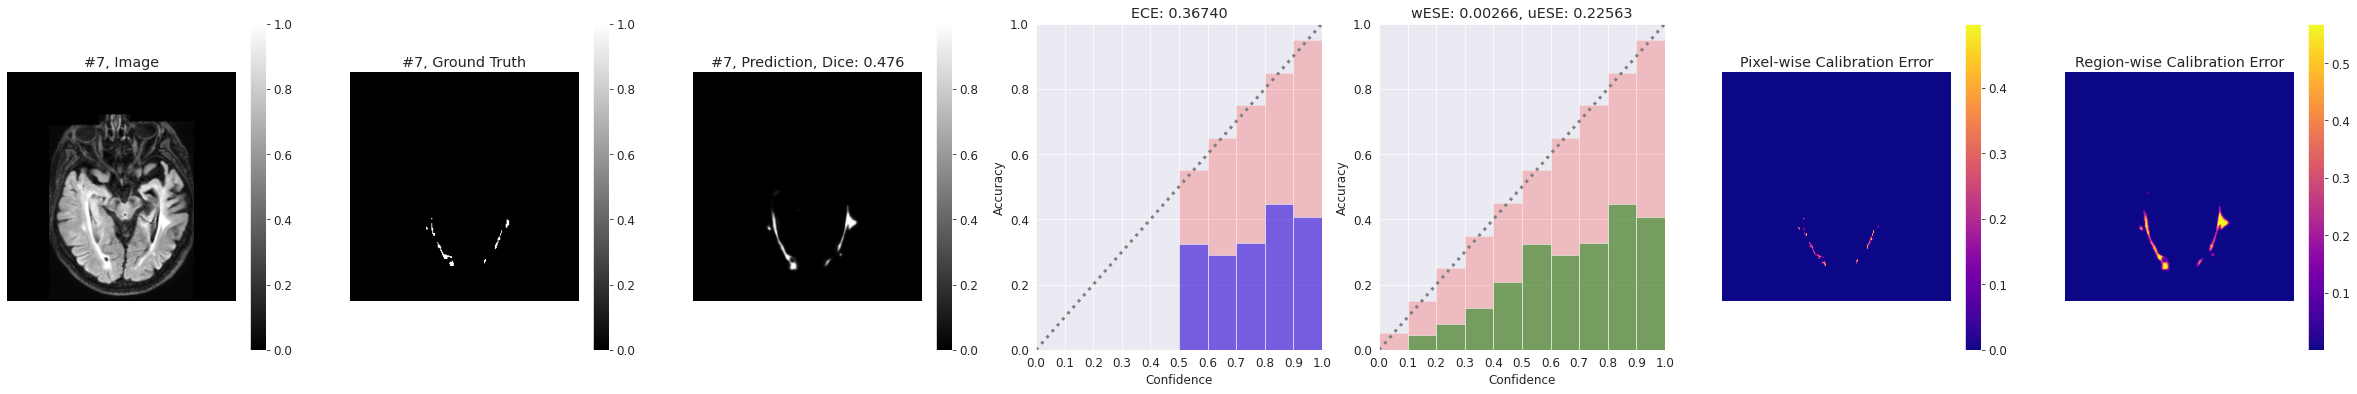

ESE: [1.76476547e-04 3.38900164e-02 1.37144595e-01 1.22606620e-01
 7.24877417e-02 1.41903728e-01 2.53870428e-01 5.26793718e-01
 1.54206932e-01 2.83015966e-02]
Accuracy: [5.35815430e-04 1.07142858e-01 1.13636367e-01 2.27272734e-01
 3.68421048e-01 4.00000006e-01 3.75000000e-01 2.50000000e-01
 1.00000000e+00 9.47368443e-01]
Bin Counts: [6.5321e+04 8.4000e+01 4.4000e+01 2.2000e+01 1.9000e+01 1.0000e+01
 8.0000e+00 4.0000e+00 5.0000e+00 1.9000e+01]


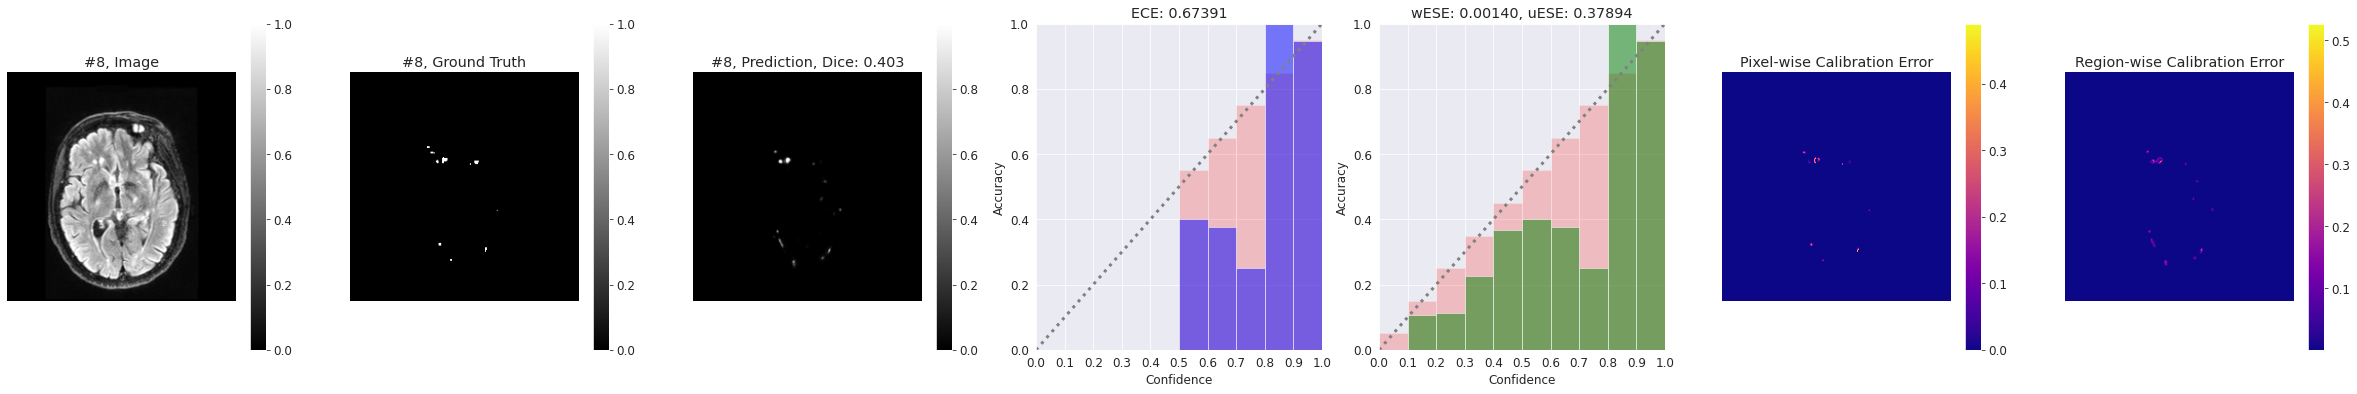

ESE: [2.6560163e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Accuracy: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Bin Counts: [65536.     0.     0.     0.     0.     0.     0.     0.     0.     0.]


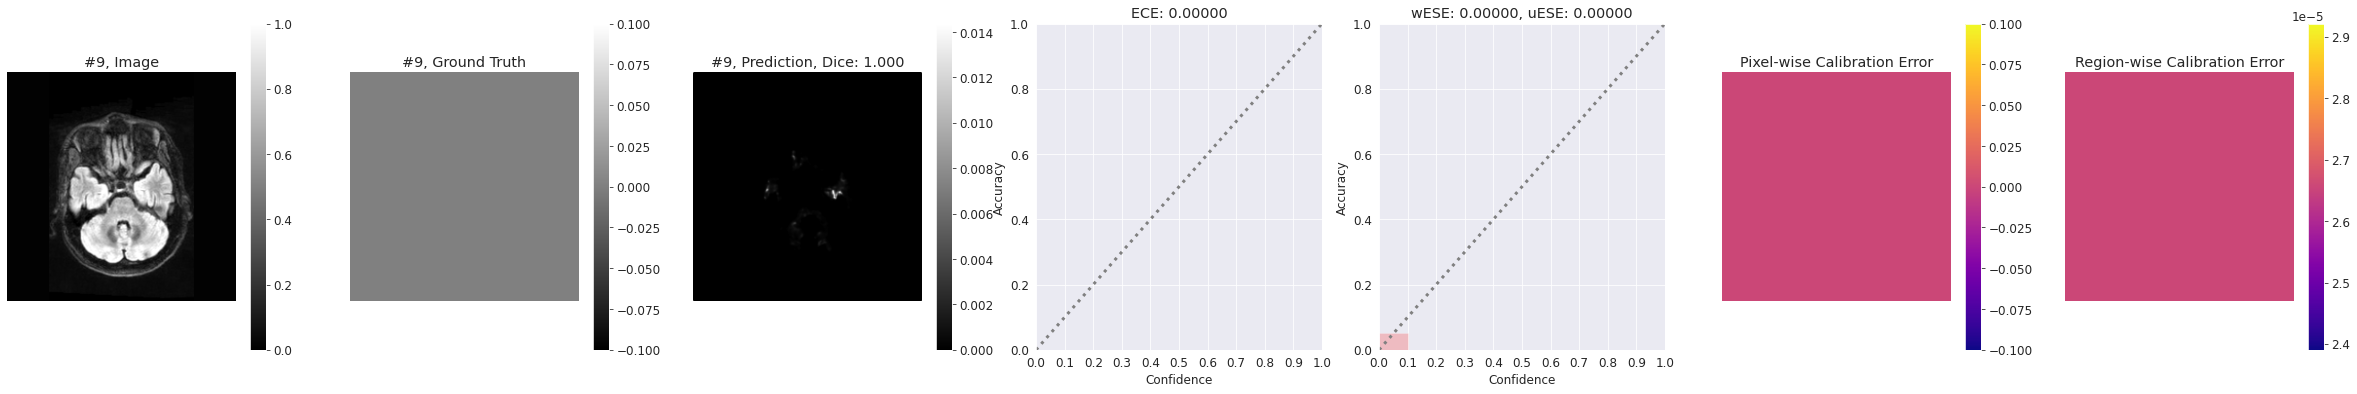

ESE: [1.48479798e-04 2.10821226e-01 1.46377861e-01 2.41850376e-01
 2.12396324e-01 1.16646260e-01 1.37943089e-01 1.96266174e-02
 1.32217407e-02 5.53449988e-02]
Accuracy: [4.92216845e-04 3.49999994e-01 4.04255331e-01 5.94594598e-01
 6.66666687e-01 4.32432443e-01 7.87878811e-01 7.61904776e-01
 8.42105269e-01 9.30000007e-01]
Bin Counts: [6.5012e+04 1.0000e+02 4.7000e+01 3.7000e+01 3.0000e+01 3.7000e+01
 3.3000e+01 2.1000e+01 1.9000e+01 2.0000e+02]


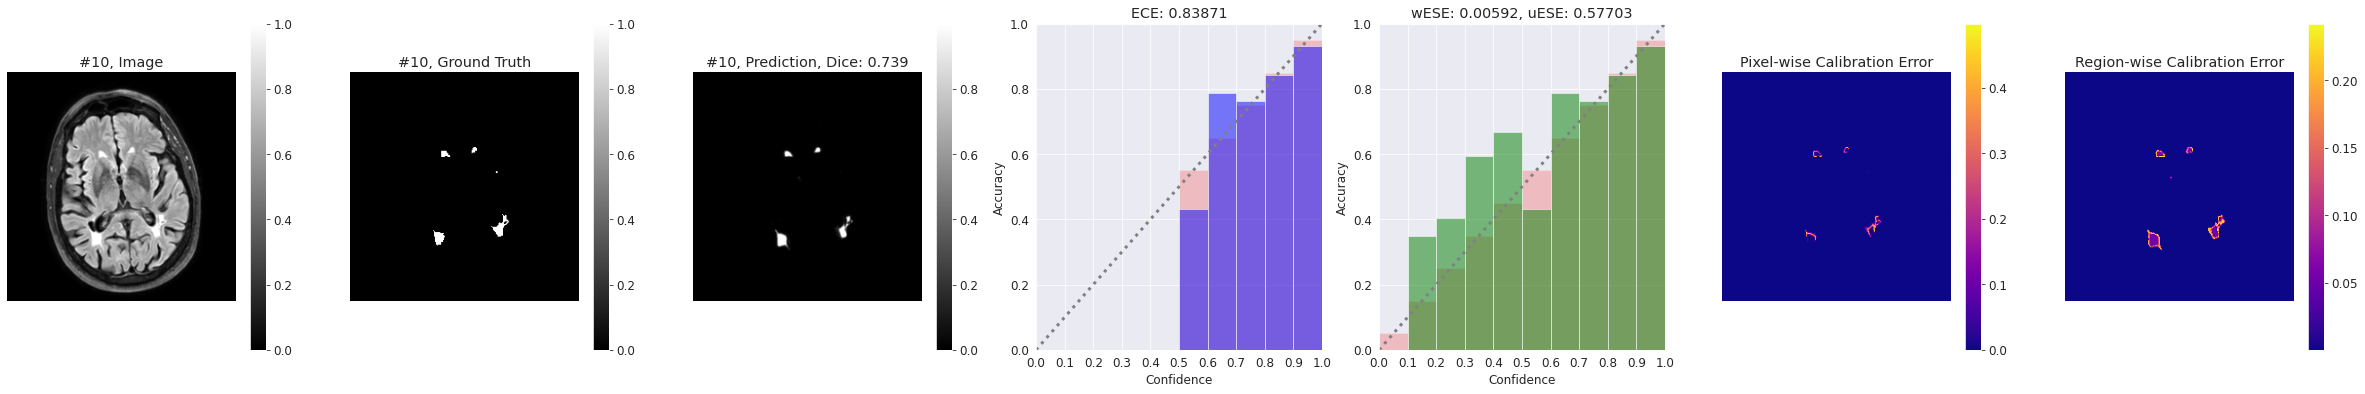

ESE: [5.30208345e-05 5.74521646e-02 2.52069831e-01 0.00000000e+00
 4.06112432e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Accuracy: [6.10537900e-05 7.69230798e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Bin Counts: [6.5516e+04 1.3000e+01 6.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


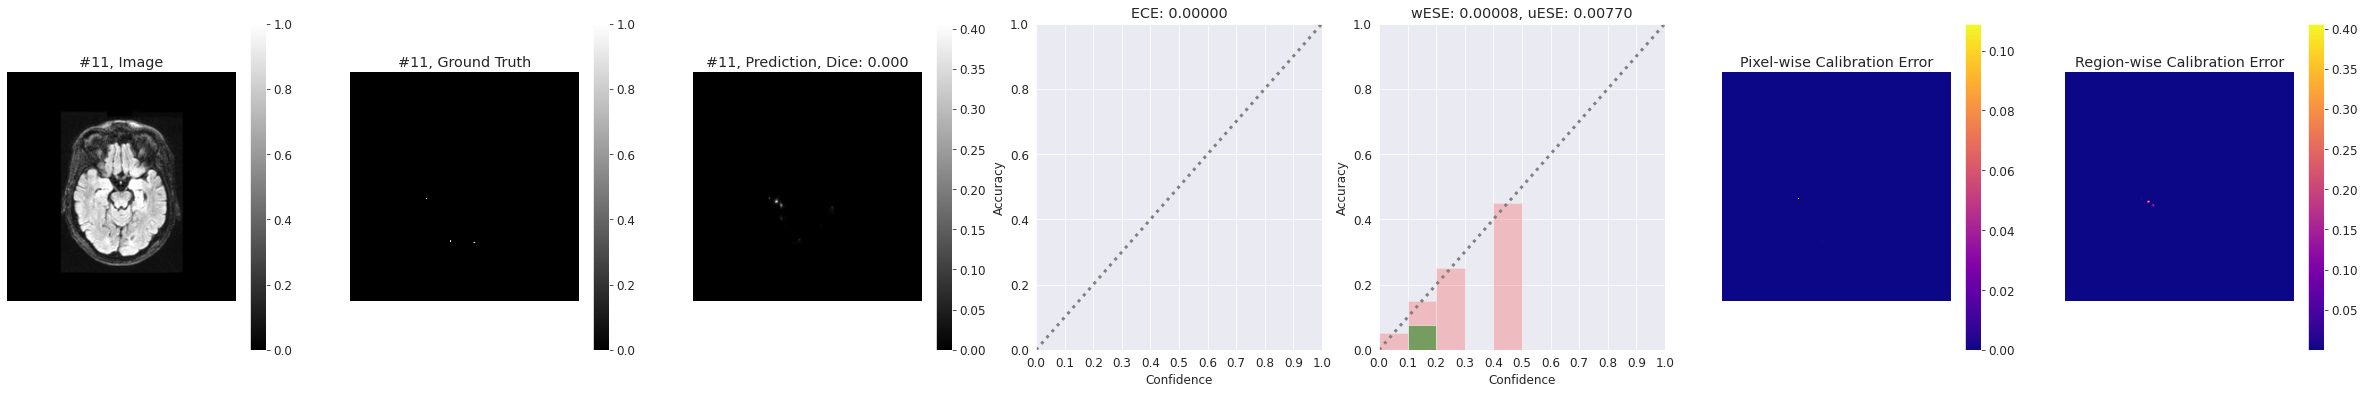

ESE: [2.10211438e-05 1.23842180e-01 1.57935441e-01 2.84274727e-01
 2.36244425e-01 1.28017992e-01 5.23692727e-01 4.55445021e-01
 1.29321456e-01 0.00000000e+00]
Accuracy: [2.59934866e-04 1.81818176e-02 7.69230798e-02 6.25000000e-02
 2.14285716e-01 4.28571433e-01 1.25000000e-01 2.85714298e-01
 1.00000000e+00 0.00000000e+00]
Bin Counts: [6.5401e+04 5.5000e+01 2.6000e+01 1.6000e+01 1.4000e+01 7.0000e+00
 8.0000e+00 7.0000e+00 2.0000e+00 0.0000e+00]


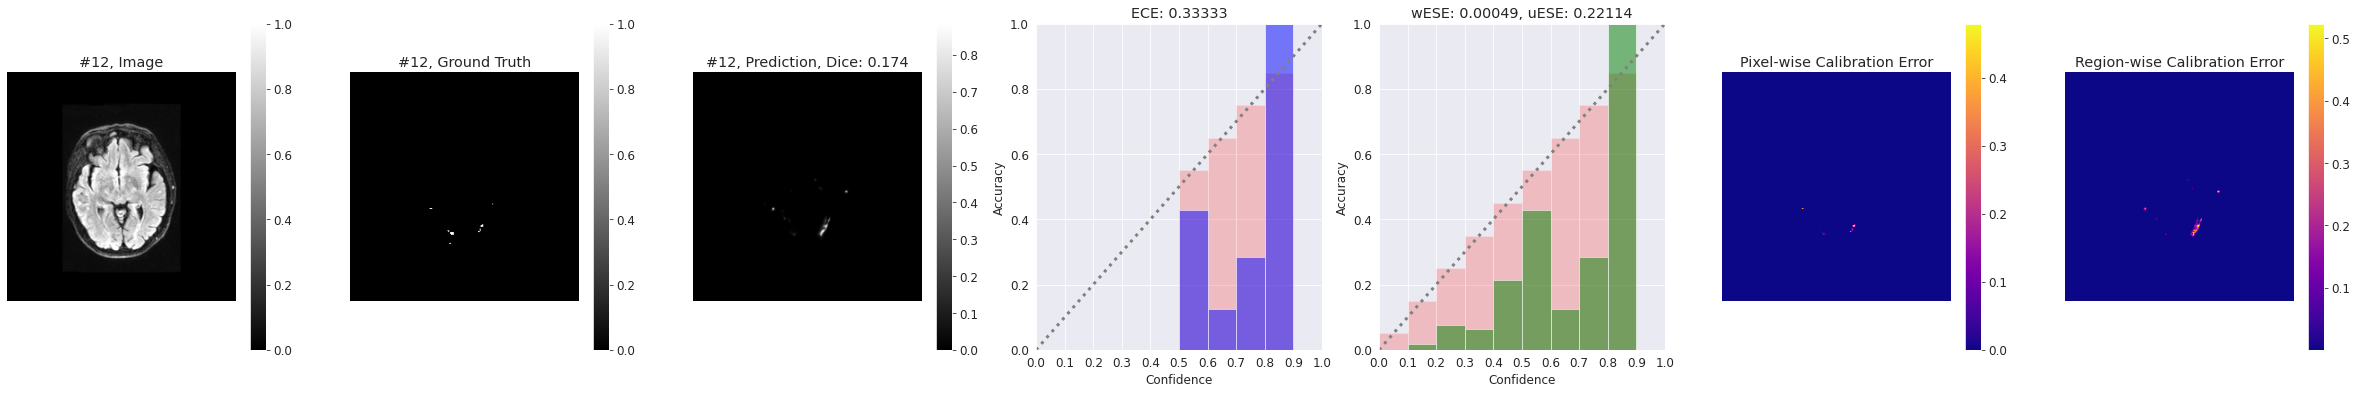

ESE: [3.06641276e-04 4.18385714e-02 1.49277806e-01 3.81228328e-03
 2.86348641e-01 3.74054730e-01 4.81534958e-01 4.94680941e-01
 7.82669961e-01 6.60429239e-01]
Accuracy: [1.07381726e-04 9.82142836e-02 9.85915512e-02 3.51351351e-01
 1.61290318e-01 1.81818187e-01 1.57894731e-01 2.50000000e-01
 6.66666701e-02 3.10344815e-01]
Bin Counts: [6.5188e+04 1.1200e+02 7.1000e+01 3.7000e+01 3.1000e+01 2.2000e+01
 1.9000e+01 1.2000e+01 1.5000e+01 2.9000e+01]


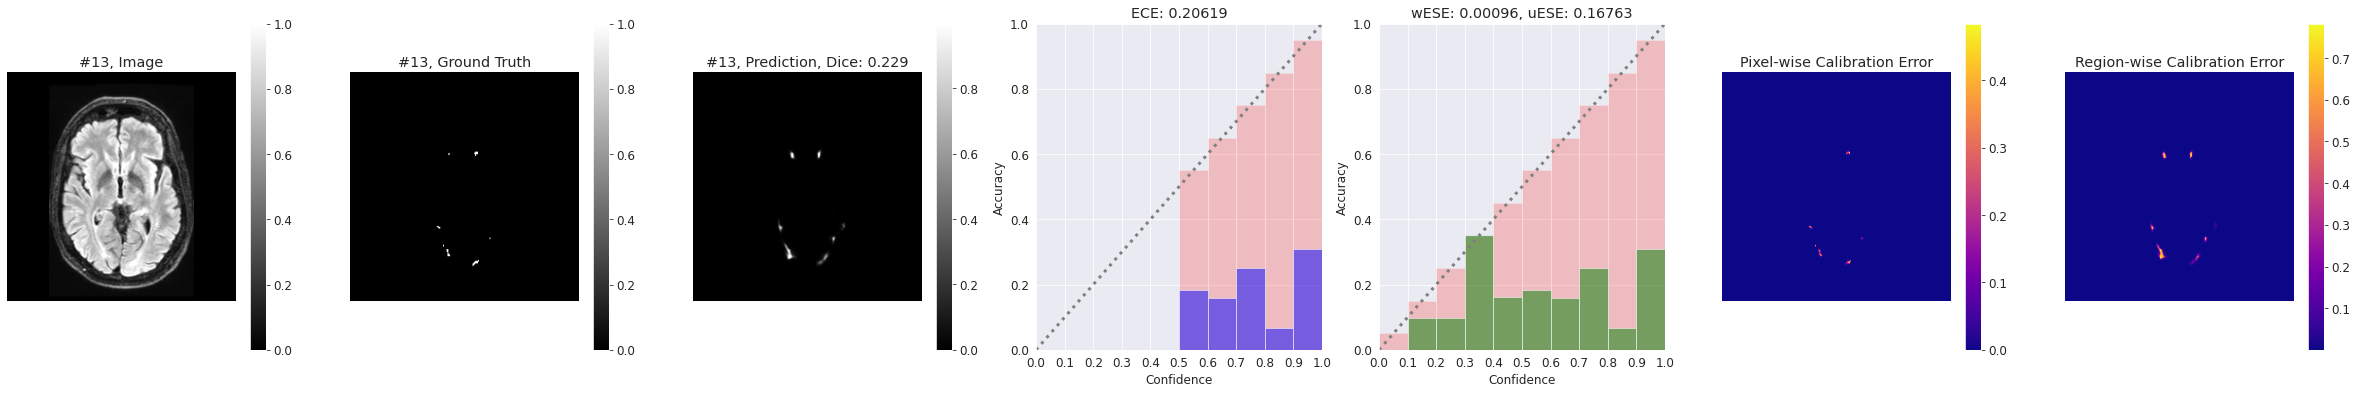

ESE: [1.73016248e-04 6.25669584e-02 1.99882448e-01 1.56181395e-01
 9.32454765e-02 3.51417959e-01 1.62148714e-01 5.62678635e-01
 2.60202050e-01 1.78488851e-01]
Accuracy: [1.53047949e-05 8.19672123e-02 4.76190485e-02 1.87500000e-01
 3.57142866e-01 2.00000003e-01 5.00000000e-01 1.66666672e-01
 5.83333313e-01 8.00000012e-01]
Bin Counts: [6.5339e+04 6.1000e+01 2.1000e+01 1.6000e+01 1.4000e+01 1.0000e+01
 1.2000e+01 6.0000e+00 1.2000e+01 4.5000e+01]


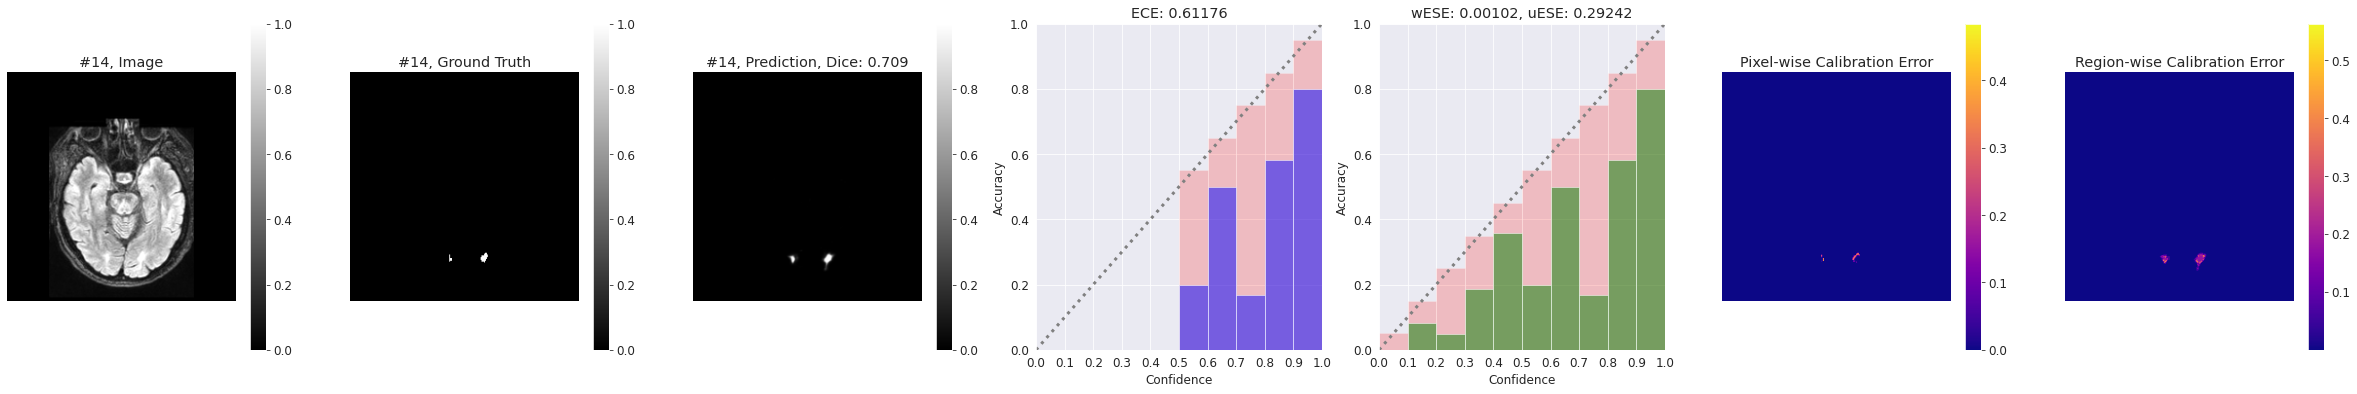

ESE: [1.81101699e-04 1.07529104e-01 1.91226244e-01 1.83133677e-01
 2.11590543e-01 5.17520487e-01 4.35825050e-01 5.05186796e-01
 6.40407860e-01 3.87269616e-01]
Accuracy: [9.17936486e-05 2.73972601e-02 5.00000007e-02 1.66666672e-01
 2.35294119e-01 0.00000000e+00 2.22222224e-01 2.50000000e-01
 2.00000003e-01 5.55555582e-01]
Bin Counts: [6.5364e+04 7.3000e+01 2.0000e+01 2.4000e+01 1.7000e+01 7.0000e+00
 9.0000e+00 8.0000e+00 5.0000e+00 9.0000e+00]


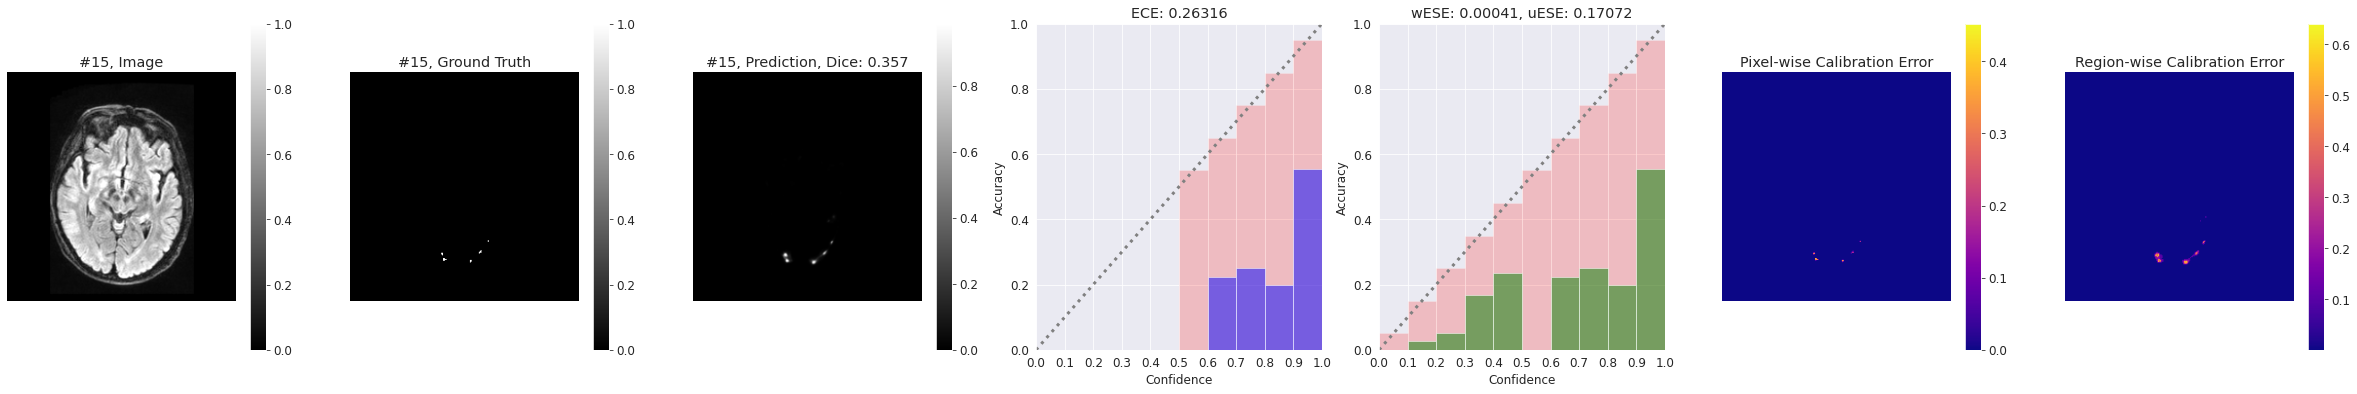

In [16]:
from ese.experiment.analysis.diagrams import subject_plot

subject_plot(
    subject_dict=predictions_dict,
    num_bins=10
)

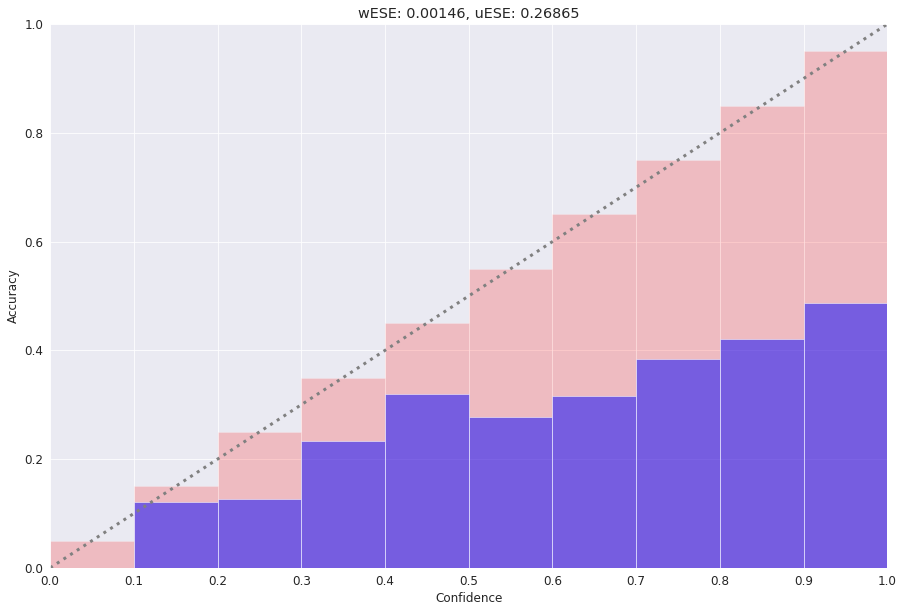

In [17]:
from ese.experiment.analysis.diagrams import aggregate_plot

aggregate_plot(
    subject_dict=predictions_dict,
    num_bins=10
)